In [3]:
# imports
from datamodel import OrderDepth, UserId, TradingState, Order, Observation, ConversionObservation
from typing import List, Dict, Tuple, Any
import string
import json
import jsonpickle
import numpy as np
import math
from math import log, sqrt, exp
from dataclasses import dataclass
from statistics import NormalDist
import random
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
file_path = "./submission.log"

In [5]:
@dataclass
class Trade:
    timestamp: int
    buyer: str
    seller: str
    symbol: str
    currency: str
    price: float
    quantity: int

def parse_logs(file_path: str) -> Tuple[str, pd.DataFrame, List[Any]]:
    # Read entire log file
    with open(file_path, 'r') as f:
        content = f.read()

    # --- Parse Sandbox Logs ---
    sandbox_start = content.find('Sandbox logs:')
    activities_start = content.find('Activities log:')
    sandbox_section = content[sandbox_start + len('Sandbox logs:'):activities_start].strip()

    # --- Parse Activities Log ---
    trades_start = content.find('Trade History:')
    activities_section = content[activities_start + len('Activities log:'):trades_start].strip()

    # Read CSV section into a DataFrame
    activities_df = pd.read_csv(StringIO(activities_section), sep=';')

    # --- Parse Trades ---
    trades_section = content[trades_start + len('Trade History:'):].strip()
    trades_data = json.loads(trades_section)

    # Convert to Trade objects
    trades: List[Any] = [Trade(**t) for t in trades_data]

    return sandbox_section, activities_df, trades

sandbox_section, activities_df, trades = parse_logs(file_path)

In [6]:
trades_df = pd.DataFrame([t.__dict__ for t in trades])
our_trades = [trade for trade in trades if trade.buyer == "SUBMISSION" or trade.seller == "SUBMISSION"]
our_trades_df = pd.DataFrame([trade.__dict__ for trade in our_trades])
print(len(our_trades_df))

53


In [7]:
# Sort the trades chronologically
our_trades_sorted = sorted(our_trades, key=lambda x: x.timestamp)

# Extract all unique timestamps and products from the activities dataframe
timestamps = sorted(activities_df['timestamp'].unique())
symbols = activities_df['product'].unique()

# Keep track of running position
running_pos = defaultdict(int)
records = []

# Pointer for iterating through our_trades_sorted
t_idx = 0

for t in timestamps:
    # Apply all trades that occurred at this timestamp
    while t_idx < len(our_trades_sorted) and our_trades_sorted[t_idx].timestamp == t:
        trade = our_trades_sorted[t_idx]
        if trade.buyer == "SUBMISSION":
            running_pos[trade.symbol] += trade.quantity
        elif trade.seller == "SUBMISSION":
            running_pos[trade.symbol] -= trade.quantity
        t_idx += 1

    # Record the position for all products at this timestamp
    for symbol in symbols:
        records.append({'timestamp': t, 'product': symbol, 'position': running_pos[symbol]})

# Create DataFrame of positions and merge
position_df = pd.DataFrame(records)
activities_df = activities_df.merge(position_df, on=['timestamp', 'product'], how='left')

# PRODUCT DICT

In [51]:
products = [
    "RAINFOREST_RESIN",
    "KELP", "SQUID_INK",
    "CROISSANTS", "JAMS",
    "DJEMBES", "PICNIC_BASKET1",
    "PICNIC_BASKET2",
    "VOLCANIC_ROCK",
    "VOLCANIC_ROCK_VOUCHER_9500", "VOLCANIC_ROCK_VOUCHER_9750",
    "VOLCANIC_ROCK_VOUCHER_10000", "VOLCANIC_ROCK_VOUCHER_10250",
    "VOLCANIC_ROCK_VOUCHER_10500", "MAGNIFICENT_MACARONS"
]

product_dict = {
    product: {
        "order_book": activities_df[activities_df['product'] == product],
        "trades": trades_df[trades_df['symbol'] == product]
    }
    for product in products
}
# check length of product_dict
print("Length of product_dict:", len(product_dict))

Length of product_dict: 15


# POSITIONS

In [52]:
product_dict["MAGNIFICENT_MACARONS"]["order_book"].head(10)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,position
0,4,0,SQUID_INK,1928.0,22.0,NaN,NaN,NaN,NaN,1931,2,1932.0,20.0,NaN,NaN,1929.5,0.0,0
18,4,100,SQUID_INK,1924.0,1.0,1923.0,27.0,NaN,NaN,1925,5,1927.0,28.0,NaN,NaN,1924.5,0.0,0
38,4,200,SQUID_INK,1927.0,24.0,NaN,NaN,NaN,NaN,1930,24,NaN,NaN,NaN,NaN,1928.5,0.0,0
46,4,300,SQUID_INK,1926.0,30.0,NaN,NaN,NaN,NaN,1929,30,NaN,NaN,NaN,NaN,1927.5,0.0,0
66,4,400,SQUID_INK,1927.0,20.0,NaN,NaN,NaN,NaN,1930,20,NaN,NaN,NaN,NaN,1928.5,0.0,0
89,4,500,SQUID_INK,1927.0,5.0,1925.0,29.0,NaN,NaN,1929,29,NaN,NaN,NaN,NaN,1928.0,0.0,0
91,4,600,SQUID_INK,1926.0,24.0,NaN,NaN,NaN,NaN,1929,24,NaN,NaN,NaN,NaN,1927.5,0.0,0
112,4,700,SQUID_INK,1931.0,4.0,1929.0,31.0,NaN,NaN,1932,31,NaN,NaN,NaN,NaN,1931.5,0.0,0
121,4,800,SQUID_INK,1934.0,23.0,NaN,NaN,NaN,NaN,1937,23,NaN,NaN,NaN,NaN,1935.5,0.0,0
138,4,900,SQUID_INK,1936.0,21.0,NaN,NaN,NaN,NaN,1940,21,NaN,NaN,NaN,NaN,1938.0,0.0,0


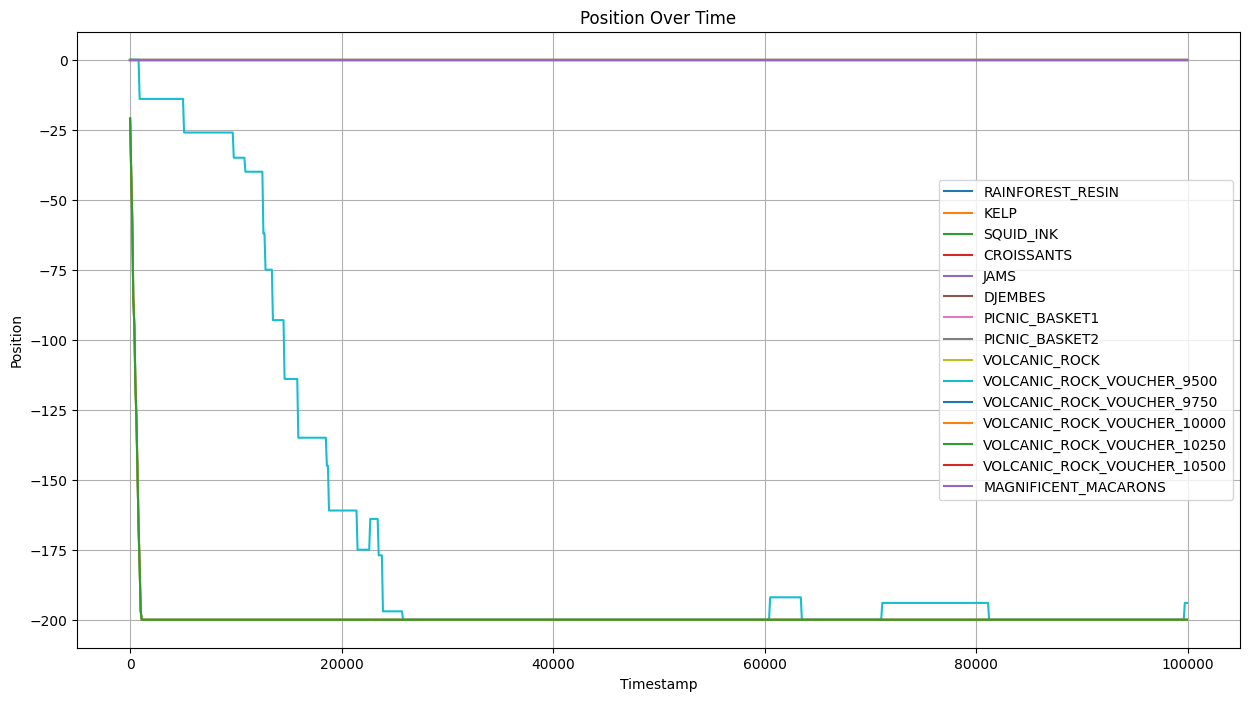

In [53]:
plt.figure(figsize=(15, 8))

for product, dict in product_dict.items():
    # Plot position
    plt.plot(dict['order_book']['timestamp'], dict['order_book']['position'], label=product)
    plt.xlabel('Timestamp')
    plt.ylabel('Position')
    plt.title('Position Over Time')
    plt.legend()
    plt.grid()


# VOLCANIC ROCK POSITIONS

In [54]:
def bisection_iv(
        S: float,
        V: float,
        K: int,
        TTT: float,
        low: float = 1e-4,
        high: float = 1.0,
        tol: float = 1e-4,
        max_iter: int = 10
) -> Tuple[float, float]:
    """
    Bisection method to find the implied volatility and delta.
    """
    N = NormalDist()
    for _ in range(max_iter):
        iv = (low + high) / 2
        d1 = (log(S / K) + (0.5 * high**2) * TTT) / (high * sqrt(TTT))
        d2 = d1 - high * sqrt(TTT)
        delta = N.cdf(d1)
        price = S * delta - K * N.cdf(d2)
        if abs(price - V) < tol:
            return iv, delta
        if price > V:
            high = iv
        else:
            low = iv
    return iv, delta

def black_scholes_price(
        S: float,
        K: int,
        TTE: float,
        iv: float,
        r: float = 0.0
) -> float:
    """
    Calculate the Black-Scholes price.
    """
    N = NormalDist()
    d1 = (log(S / K) + (0.5 * iv**2) * TTE) / (iv * sqrt(TTE))
    d2 = d1 - iv * sqrt(TTE)
    call_price = S * N.cdf(d1) - K * exp(-r * TTE) * N.cdf(d2)
    return call_price


def add_volcanic_rock_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each row in df (with columns 'timestamp' and 'mid_price'), compute:
      - iv_{strike}, delta_{strike}
      - moneyness_{strike}
      - iv_fit_{strike}, misvol_{strike}, fair_{strike}
    for strikes = [9500, 9750, 10000, 10250, 10500], and append all as new cols.
    """
    strikes = [9500, 9750, 10000, 10250, 10500]
    
    def compute_row(row):
        S = row['mid_price']
        TTE = (3e6 - row['timestamp']) / (1e6 * 365)
        out = {}
        # 1) raw IV + delta + moneyness
        for K in strikes:
            # assume you've pre–merged in the voucher mid‐prices as e.g. mid_price_9500, etc.
            V = row[f'mid_price_{K}']
            iv, delta = bisection_iv(S, V, K, TTE)
            m = np.log(K / S) / np.sqrt(TTE)
            out[f'iv_{K}'] = iv
            out[f'delta_{K}'] = delta
            out[f'moneyness_{K}'] = m
        
        # 2) fit a quadratic IV curve
        m_vals = [out[f'moneyness_{K}'] for K in strikes]
        iv_vals = [out[f'iv_{K}']       for K in strikes]
        a, b, c = np.polyfit(m_vals, iv_vals, 2)
        
        # 3) iv_fit, misvol, fair
        for K in strikes:
            m = out[f'moneyness_{K}']
            iv_fit = a*m*m + b*m + c
            fair = black_scholes_price(S, K, TTE, out[f'iv_{K}'])
            out[f'iv_fit_{K}']  = iv_fit
            out[f'misvol_{K}']  = out[f'iv_{K}'] - iv_fit
            out[f'fair_{K}']    = fair
        
        return pd.Series(out)
    
    # apply row‐wise and concat
    metrics = df.apply(compute_row, axis=1)
    return pd.concat([df, metrics], axis=1)

In [63]:
volcanic_rock_df = product_dict["VOLCANIC_ROCK"]["order_book"].copy()

for K in [9500, 9750, 10000, 10250, 10500]:
    volcanic_rock_df[f'mid_price_{K}'] = product_dict[f"VOLCANIC_ROCK_VOUCHER_{K}"]["order_book"]['mid_price']

volcanic_rock_df = volcanic_rock_df.copy()

volcanic_rock_df = add_volcanic_rock_metrics(volcanic_rock_df)


In [64]:
# for each strike print a summary of fair price and mid price
for K in [9500, 9750, 10000, 10250, 10500]:
    print(f"Strike {K}:")
    print(volcanic_rock_df[[f'mid_price_{K}', f'fair_{K}']].describe())

Strike 9500:
       mid_price_9500    fair_9500
count             0.0  1000.000000
mean              NaN   603.707684
std               NaN    11.136128
min               NaN   579.416810
25%               NaN   595.179847
50%               NaN   602.274400
75%               NaN   612.351636
max               NaN   631.676160
Strike 9750:
       mid_price_9750    fair_9750
count             0.0  1000.000000
mean              NaN   449.179498
std               NaN     9.421128
min               NaN   428.838116
25%               NaN   441.744397
50%               NaN   448.298328
75%               NaN   456.790825
max               NaN   472.755202
Strike 10000:
       mid_price_10000   fair_10000
count              0.0  1000.000000
mean               NaN   322.579803
std                NaN     7.653308
min                NaN   306.274408
25%                NaN   316.200163
50%                NaN   322.238183
75%                NaN   328.912139
max                NaN   341.610898
Strike

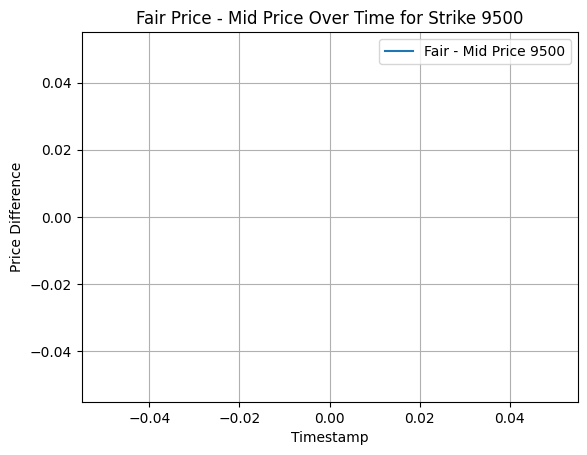

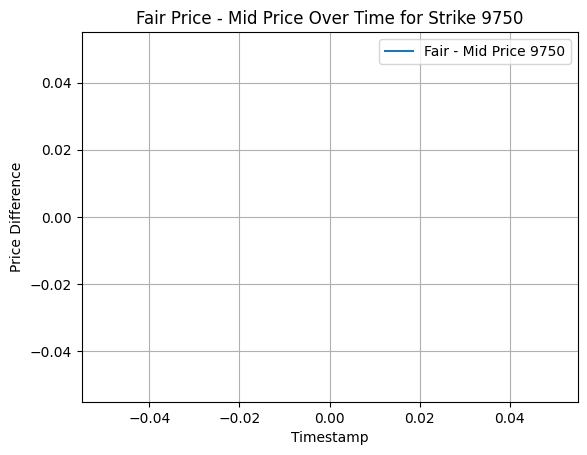

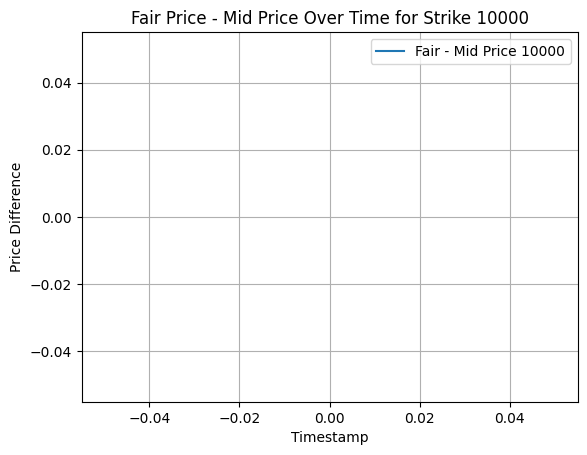

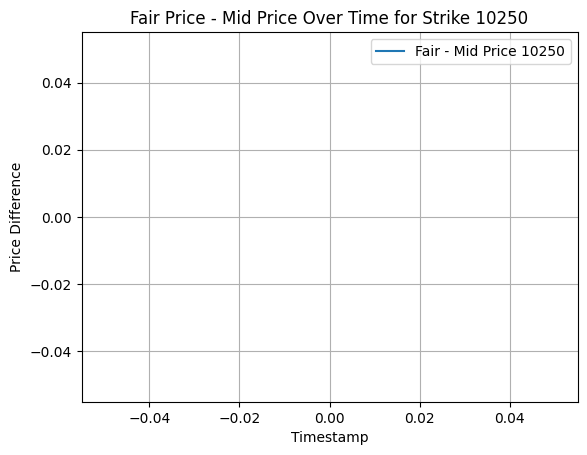

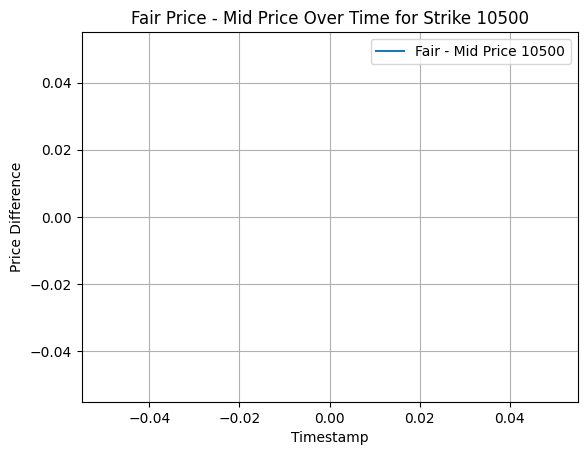

In [ ]:
for K in [9500, 9750, 10000, 10250, 10500]:
    plt.plot(volcanic_rock_df['timestamp'], volcanic_rock_df[f'fair_{K}'] - volcanic_rock_df[f'mid_price_{K}'], label=f'Fair - Mid Price {K}')
    plt.xlabel('Timestamp')
    plt.ylabel('Price Difference')
    plt.title(f'Fair Price - Mid Price Over Time for Strike {K}')
    plt.legend()
    plt.grid()
    plt.show()